#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from week6.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch
from sklearn.model_selection import KFold

In [3]:
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=de0f4407-ddbf-4761-b959-637116a5f55a
To: /home/jupyter/week7/IT_data.h5
100%|██████████| 384M/384M [00:06<00:00, 60.5MB/s] 


'IT_data.h5'

### Load the data

In [4]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [5]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [6]:
stimulus_val.shape

(288, 3, 224, 224)

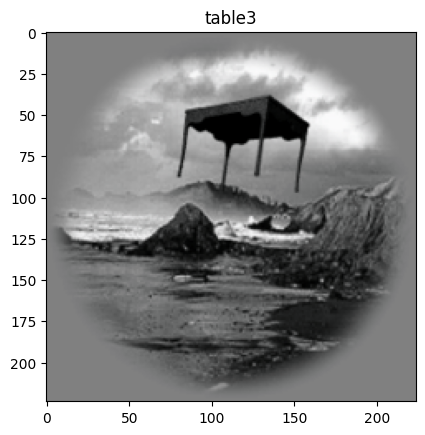

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

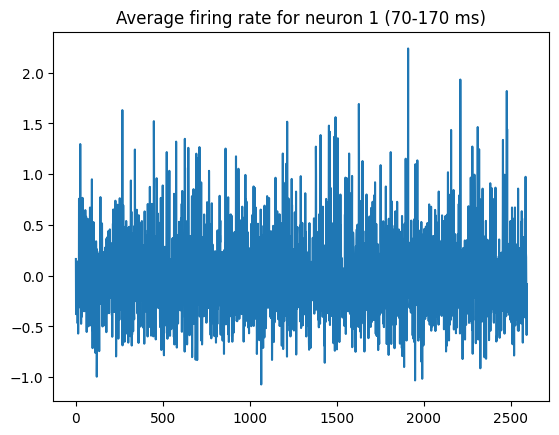

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [9]:
### Create the dataloder
from torch.utils.data import DataLoader, TensorDataset
import torch

X_train = torch.tensor(stimulus_train, dtype=torch.float32)
Y_train = torch.tensor(spikes_train, dtype=torch.float32)
X_val = torch.tensor(stimulus_val, dtype=torch.float32)
Y_val = torch.tensor(spikes_val, dtype=torch.float32)
X_test = torch.tensor(stimulus_test, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)

train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [10]:
Y_train.shape

torch.Size([2592, 168])

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class My_CNNLessFilters(nn.Module):
    def __init__(self, output_features, dropout_rate=0.2):
        super(My_CNNLessFilters, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculated dimensions after conv and pool
        size_after_conv = 222  # (224 - 3 + 2 * 0) / 1 + 1 = 222
        size_after_pool = 111  # (222 - 2) / 2 + 1 = 111

        # Flatten output dimensions for the fully connected layer
        in_features = 16 * size_after_pool * size_after_pool
        self.fc = nn.Linear(in_features=in_features, out_features=output_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 16 * 111 * 111)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x


In [12]:
### Define the loss function (MSE) and the optimizer
modelLessFilters = My_CNNLessFilters(output_features = Y_train.shape[1], dropout_rate=0.2)
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(modelLessFilters.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(modelLessFilters.parameters(), lr=0.001, weight_decay =0.05)

FOLD 1
--------------------------------
Epoch 1 Loss: 0.3539
Fold 0, Average Validation Loss: 0.1319


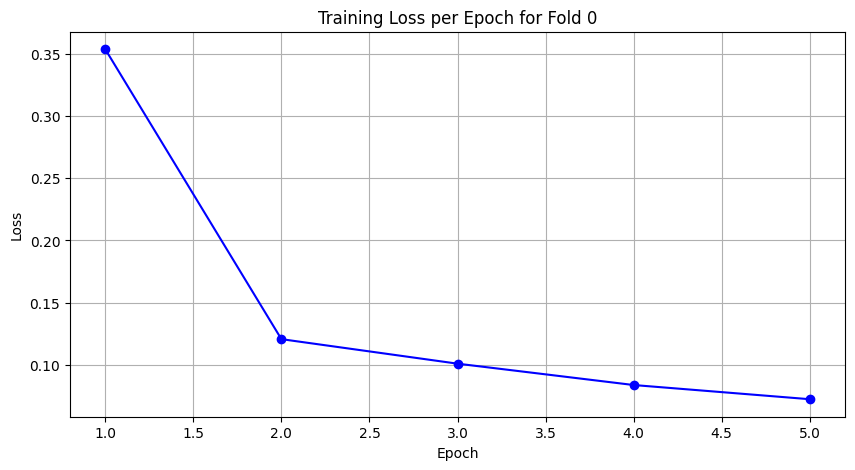

FOLD 2
--------------------------------
Epoch 1 Loss: 0.0840
Fold 1, Average Validation Loss: 0.0651


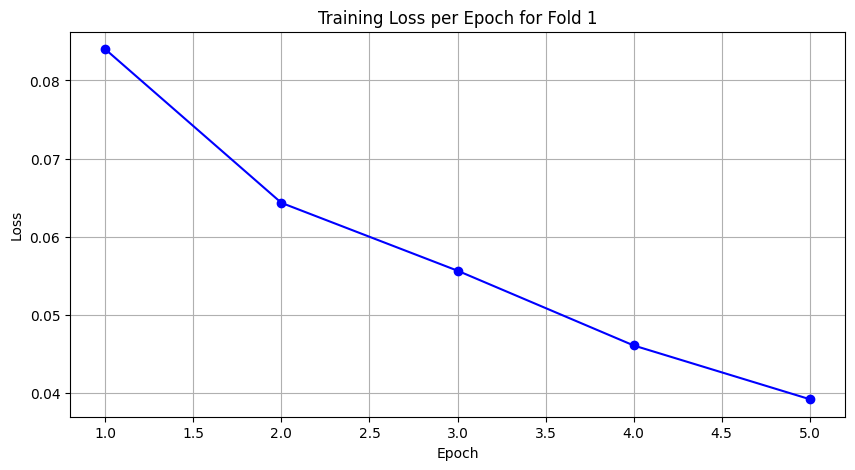

FOLD 3
--------------------------------
Epoch 1 Loss: 0.0471
Fold 2, Average Validation Loss: 0.0368


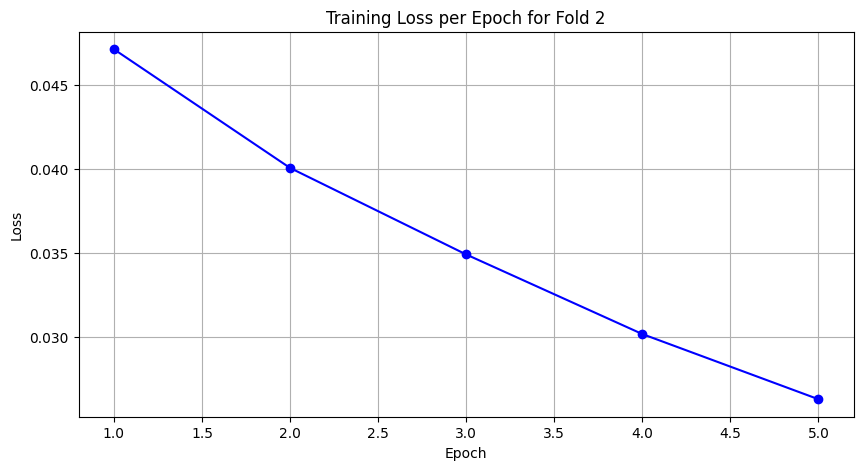

FOLD 4
--------------------------------
Epoch 1 Loss: 0.0290
Fold 3, Average Validation Loss: 0.0259


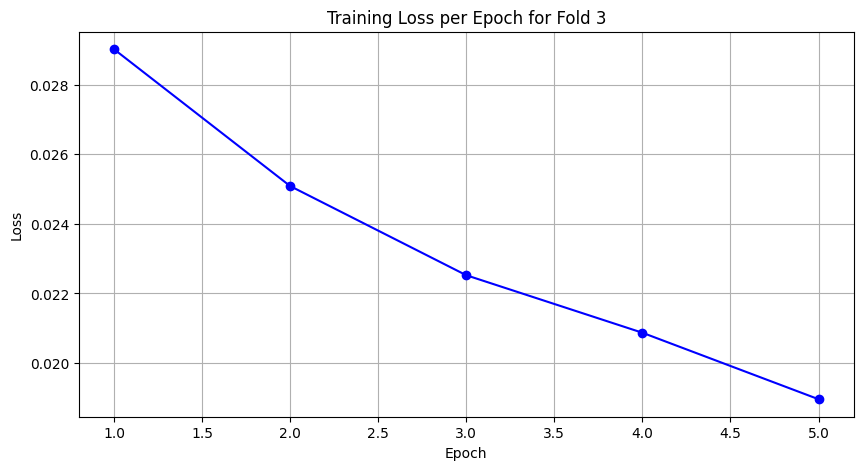

FOLD 5
--------------------------------
Epoch 1 Loss: 0.0218
Fold 4, Average Validation Loss: 0.0199


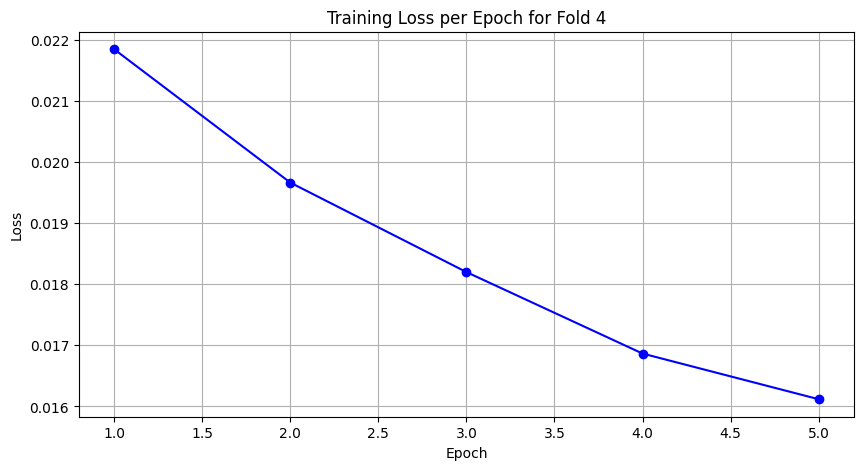

K-Fold Validation Results: {0: 0.13192904652918086, 1: 0.06511461953906451, 2: 0.03681944266838186, 3: 0.025882294511093813, 4: 0.019936685614726123}


In [13]:

dataset = TensorDataset(X_train, Y_train)

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# Define the loss function and optimizer outside the folds loop
criterion = nn.MSELoss()
optimizer = optim.Adam(modelLessFilters.parameters(), lr=0.0001) 

results = {}

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(dataset, train_ids)
    test_subsampler = Subset(dataset, test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_dataloader = DataLoader(train_subsampler, batch_size=32, shuffle=True)
    validation_dataloader = DataLoader(test_subsampler, batch_size=32, shuffle=False)
    
    n_epochs = 5
    losses = []  # List to store loss values for plotting
    j=0
    losses = []  # List to store loss values
    threshold = 0.0005  # Minimum decrease in loss to not trigger the warning
    patience = 3  # Number of epochs to wait before sending a warning
    patience_counter = 0  # Counter to track the number of epochs below the threshold
    start1=time.time()
    
    for epoch in range(n_epochs):
        # Training
        epoch_losses = []
        modelLessFilters.train()
        for X, Y in train_dataloader:
            optimizer.zero_grad()
            outputs = modelLessFilters(X)
            loss = criterion(outputs, Y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        # Calculate average loss for this fold's epoch
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)
        
        # Optional: Print epoch number and loss for this fold
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1} Loss: {avg_loss:.4f}')

    # Evaluation for this fold
    modelLessFilters.eval()
    total_loss = 0
    with torch.no_grad():
        for X, Y in validation_dataloader:
            outputs = modelLessFilters(X)
            loss = criterion(outputs, Y)
            total_loss += loss.item()

    avg_val_loss = total_loss / len(validation_dataloader)
    print(f'Fold {fold}, Average Validation Loss: {avg_val_loss:.4f}')
    results[fold] = avg_val_loss

    # Plotting the training losses after each fold
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), losses, marker='o', linestyle='-', color='b')
    plt.title(f'Training Loss per Epoch for Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Print fold results
print(f'K-Fold Validation Results: {results}')


In [14]:
### Model evaluation
modelLessFilters.eval()
validation_dataloader = DataLoader(val_ds, batch_size=32, shuffle=False)

predictions = []
ground_truth = []

with torch.no_grad():  
    for X_val, Y_val in validation_dataloader:
        outputs = modelLessFilters(X_val)
        loss = criterion(outputs, Y_val)
        epoch_losses.append(loss.item())
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        predictions.append(outputs)
        ground_truth.append(Y_val)

predictions = torch.cat(predictions, dim=0)
ground_truth = torch.cat(ground_truth, dim=0)
print(avg_loss)
       

0.030106491472169355


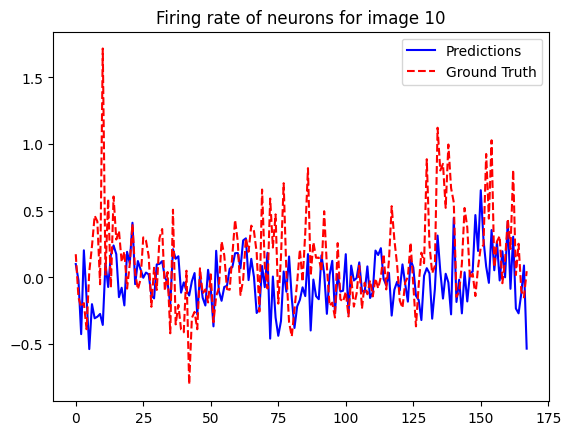

In [15]:
img_idx = 10

plt.figure()
plt.title(f'Firing rate of neurons for image {img_idx}')
plt.plot(predictions[img_idx, :], color='blue', label='Predictions')
plt.plot(ground_truth[img_idx, :], color='red', linestyle='--', label='Ground Truth')
plt.legend()
plt.show()

0.021115696854996594


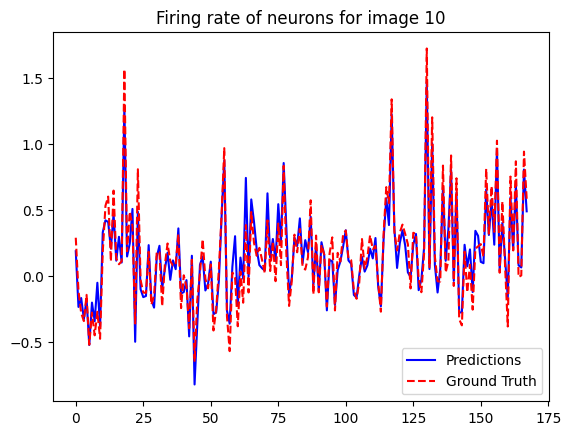

In [16]:
predictions_tr = []
ground_truth_tr = []

with torch.no_grad():  
    for X_tr, Y_tr in train_dataloader:
        outputs = modelLessFilters(X_tr)
        loss = criterion(outputs, Y_tr)
        epoch_losses.append(loss.item())
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        predictions_tr.append(outputs)
        ground_truth_tr.append(Y_tr)

predictions_tr= torch.cat(predictions_tr, dim=0)
ground_truth_tr = torch.cat(ground_truth_tr, dim=0)
print(avg_loss)
       

img_idx = 10

plt.figure()
plt.title(f'Firing rate of neurons for image {img_idx}')
plt.plot(predictions_tr[img_idx, :], color='blue', label='Predictions')
plt.plot(ground_truth_tr[img_idx, :], color='red', linestyle='--', label='Ground Truth')
plt.legend()
plt.show()

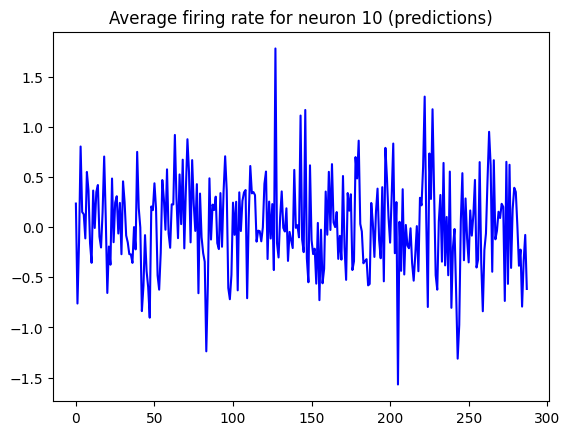

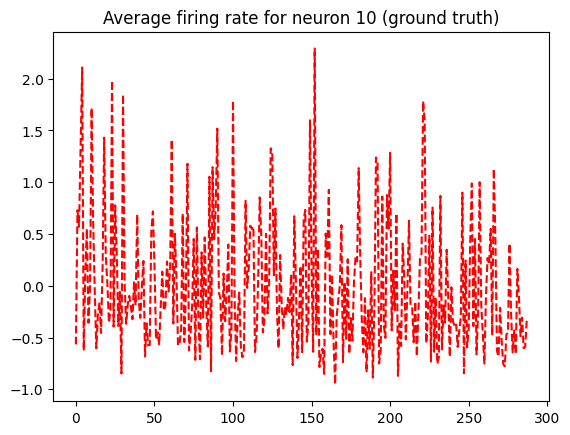

In [17]:
neuron_idx = 10

plt.figure()
plt.title('Average firing rate for neuron {} (predictions)'.format(neuron_idx))
plt.plot(predictions[:, neuron_idx], color='blue', label='Predictions')
plt.show()

plt.figure()
plt.title('Average firing rate for neuron {} (ground truth)'.format(neuron_idx))
plt.plot(ground_truth[:, neuron_idx], color='red', linestyle='--', label='Ground Truth')
plt.show()

## Explained variance and correlation

### Validation 

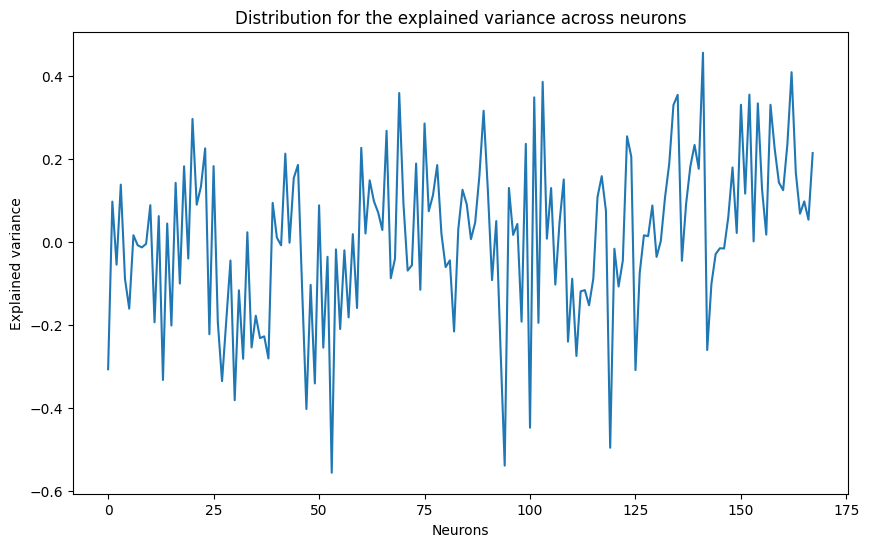

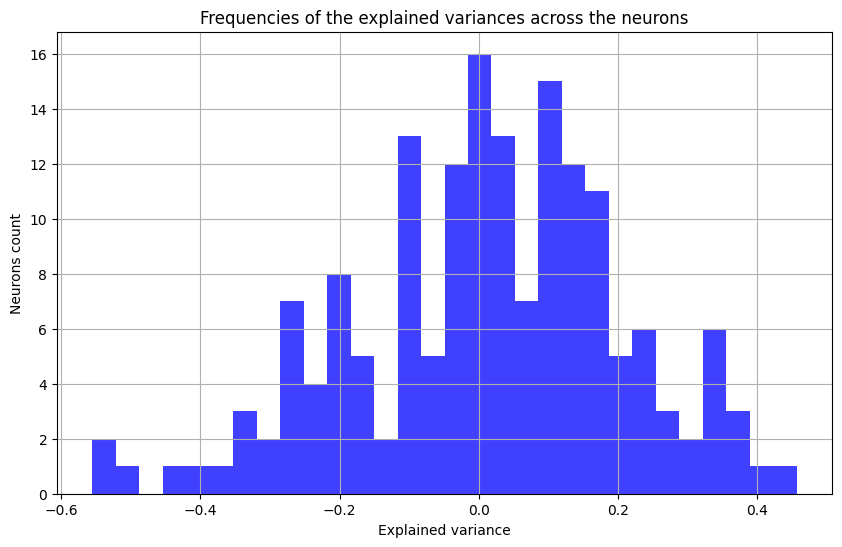

In [18]:
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

correlations = [np.corrcoef(ground_truth[:, i], predictions[:, i])[0, 1] for i in range(Y_val.shape[1])]

explained_variances = [explained_variance_score(ground_truth[:, i], predictions[:, i]) for i in range(Y_val.shape[1])]


plt.figure(figsize=(10, 6))
plt.plot(explained_variances)
plt.title('Distribution for the explained variance across neurons')
plt.xlabel('Neurons')
plt.ylabel('Explained variance')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(explained_variances, bins=30, alpha=0.75, color='blue')
plt.title('Frequencies of the explained variances across the neurons')
plt.xlabel('Explained variance')
plt.ylabel('Neurons count')
plt.grid(True)
plt.show()

In [19]:
print('Explained variance, shallow NN: ', np.mean(explained_variances))
print('Pearson correlation, shallow NN: ', np.mean(correlations))

Explained variance, shallow NN:  0.011398114618800935
Pearson correlation, shallow NN:  0.3753466575616418


### Training

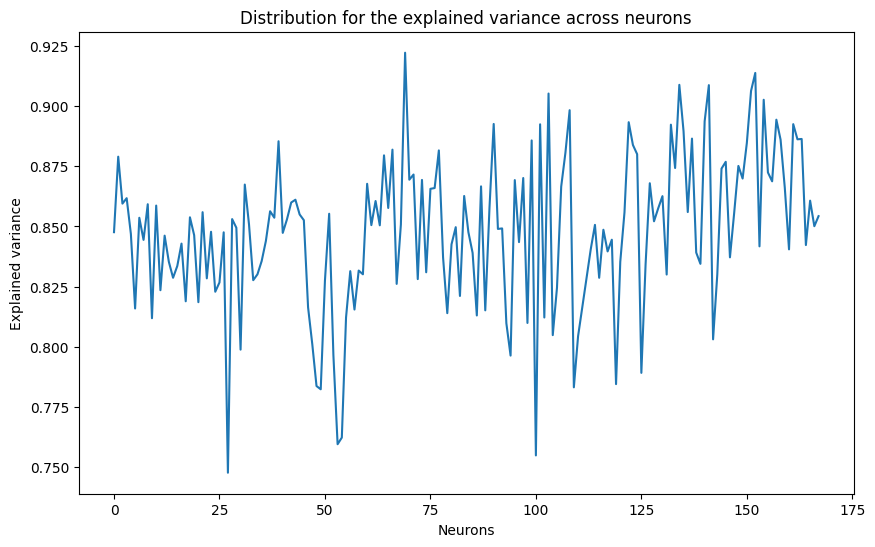

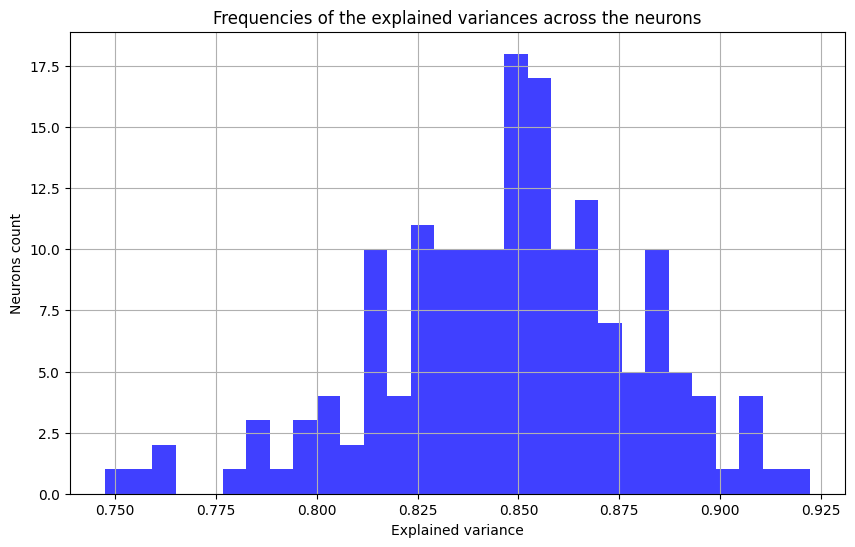

In [19]:
explained_variances_tr = [explained_variance_score(ground_truth_tr[:, i], predictions_tr[:, i]) for i in range(Y_val.shape[1])]


plt.figure(figsize=(10, 6))
plt.plot(explained_variances_tr)
plt.title('Distribution for the explained variance across neurons')
plt.xlabel('Neurons')
plt.ylabel('Explained variance')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(explained_variances_tr, bins=30, alpha=0.75, color='blue')
plt.title('Frequencies of the explained variances across the neurons')
plt.xlabel('Explained variance')
plt.ylabel('Neurons count')
plt.grid(True)
plt.show()

In [23]:
#Saves the model

torch.save(modelLessFilters, path_to_data + 'model.pt')

In [24]:
modelLoad = torch.load('model.pt')